## Preliminares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA


algorithm_globals.random_seed = 42


from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere, plot_sampled_features, get_binary_dataset
from QWNN import  quantum_weightless_neuron_ry, quantum_weightless_nn
from quantum_encoding import angle_encoding
from Aux_QuantumML import get_opflow_qnn,apply_circuit, get_bloch_coordinates, get_statevector, ttn



Experimentos com uma Rede no dataset Iris

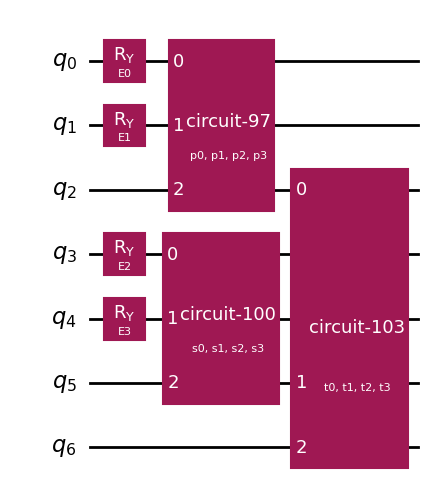

In [2]:
hamiltonian_qwnn = Z ^ I ^ I ^ I ^ I ^ I ^ I
qwnn_qc = QuantumCircuit(7)
feature_map = angle_encoding(4)
qwnn_qc.append(feature_map, [0,1,3,4])
ansatz_qwnn= quantum_weightless_nn()
qwnn_qc.append(ansatz_qwnn, [0,1,2,3,4,5,6])

qwnn_qc.decompose().draw('mpl', style='iqx')


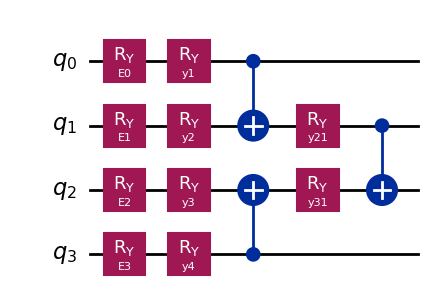

In [3]:
hamiltonian_ttn = I ^ Z ^ I ^ I 
ttn_qc = QuantumCircuit(4)
ttn_qc.append(feature_map, [0,1,2,3])
ansatz_ttn= ttn()
ttn_qc.append(ansatz_ttn, [0,1,2,3])
ttn_qc.decompose().draw('mpl', style='iqx')


In [4]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    

def run_experiments(X, y, n_times, ansatz_chosen= "QWNN", apply_pca = False, pca_components = 4):
    if(ansatz_chosen=="QWNN"):
        quantum_circuit = qwnn_qc
        ansatz = ansatz_qwnn
        hamiltonian = hamiltonian_qwnn
    if(ansatz_chosen=="TTN"):
        quantum_circuit = ttn_qc
        ansatz = ansatz_ttn
        hamiltonian = hamiltonian_ttn
    normalization = np.pi
    score_list = []
    if(apply_pca): pca = PCA(pca_components)
    for i in range(n_times):
        print("iteracao :", i)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
        if(apply_pca):
            X_train_new = pca.fit_transform(X_train)
            X_test_new = pca.transform(X_test)
        else:
            X_train_new, X_test_new = X_train, X_test
        minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_new)
        X_train_new = minmax_scale.transform(X_train_new)
        X_test_new = minmax_scale.transform(X_test_new)
        qnn = get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian)
        clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
        clf.fit(X_train_new, y_train)
        score = clf.score(X_test_new, y_test)
        score_list.append(score)
        print("score: ", score)
    print("Mean: ", np.mean(score_list))
    print("Std: ", np.std(score_list))
    print(score_list)
    return score_list

# Base de dados selecionada:

In [17]:
class_a = 1
class_b = 2
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

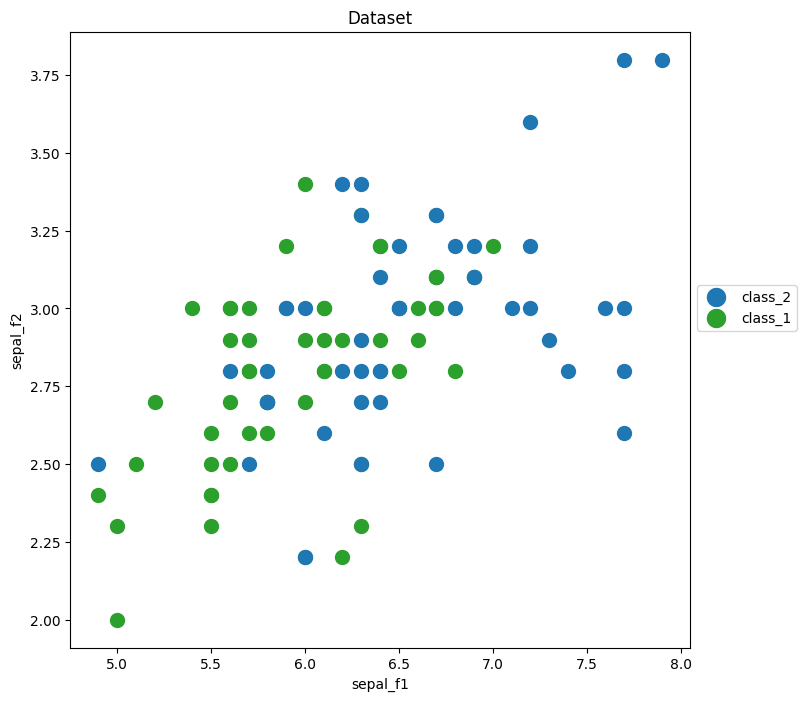

In [19]:
plot_sampled_features(X[:, [0,1]], y, axis_x_name='sepal_f1', axis_y_name='sepal_f2', class_name_minus="class_1", class_name_plus="class_2")

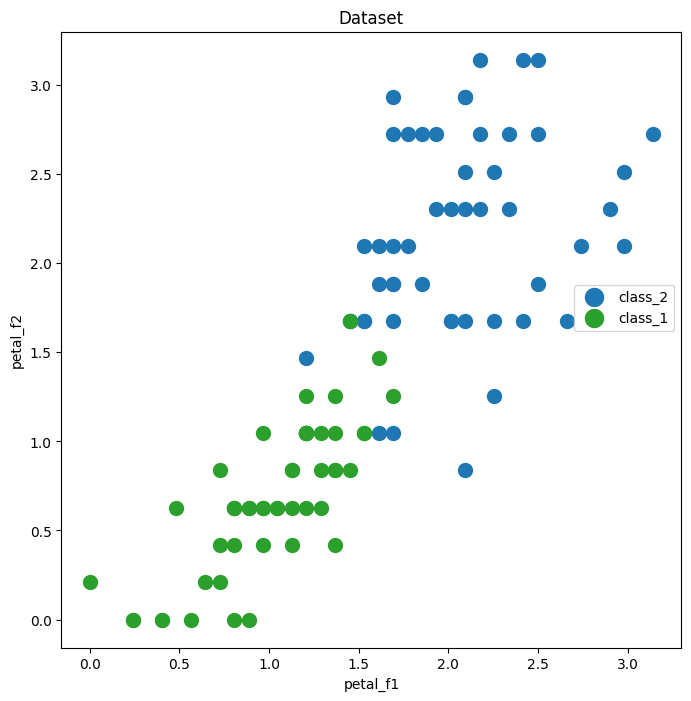

In [21]:
plot_sampled_features(X[:, [2,3]], y, axis_x_name='petal_f1', axis_y_name='petal_f2', class_name_minus="class_1", class_name_plus="class_2")

## QWNN

### 1 vez + Grafico


In [ ]:
class_a = 0
class_b = 1
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

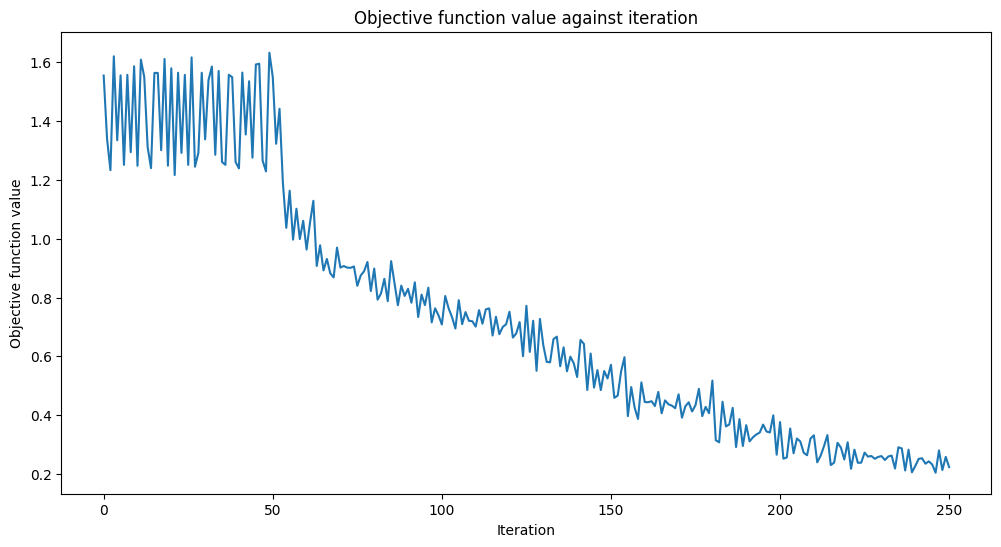

1.0

In [27]:
qnn = get_opflow_qnn(qwnn_qc, feature_map, ansatz_qwnn, hamiltonian_qwnn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train)
X_train_norm = minmax_scale.transform(X_train)
X_test_norm = minmax_scale.transform(X_test)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# fit classifier to data
opflow_classifier.fit(X_train_norm, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)
# score classifier
opflow_classifier.score(X_test_norm, y_test)

### N vezes

Classes 1 e 2

In [9]:
class_a = 0
class_b = 1
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="QWNN")

iteracao : 0
score:  1.0
iteracao : 1
score:  1.0
iteracao : 2
score:  1.0
iteracao : 3
score:  1.0
iteracao : 4
score:  1.0
Mean:  1.0
Std:  0.0
[1.0, 1.0, 1.0, 1.0, 1.0]


Classes 1 e 3

In [13]:
class_a = 0
class_b = 2
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="QWNN")

iteracao : 0
score:  1.0
iteracao : 1
score:  1.0
iteracao : 2
score:  0.95
iteracao : 3
score:  0.95
iteracao : 4
score:  0.95
Mean:  0.9700000000000001
Std:  0.024494897427831806
[1.0, 1.0, 0.95, 0.95, 0.95]


Classes 2 e 3

In [12]:
class_a = 1
class_b = 2
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="QWNN")

iteracao : 0
score:  1.0
iteracao : 1
score:  0.95
iteracao : 2
score:  0.9
iteracao : 3
score:  1.0
iteracao : 4
score:  1.0
Mean:  0.97
Std:  0.039999999999999994
[1.0, 0.95, 0.9, 1.0, 1.0]


# TTN

### Circuito

### 1 vez + Grafico

In [7]:
class_a = 0
class_b = 1
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

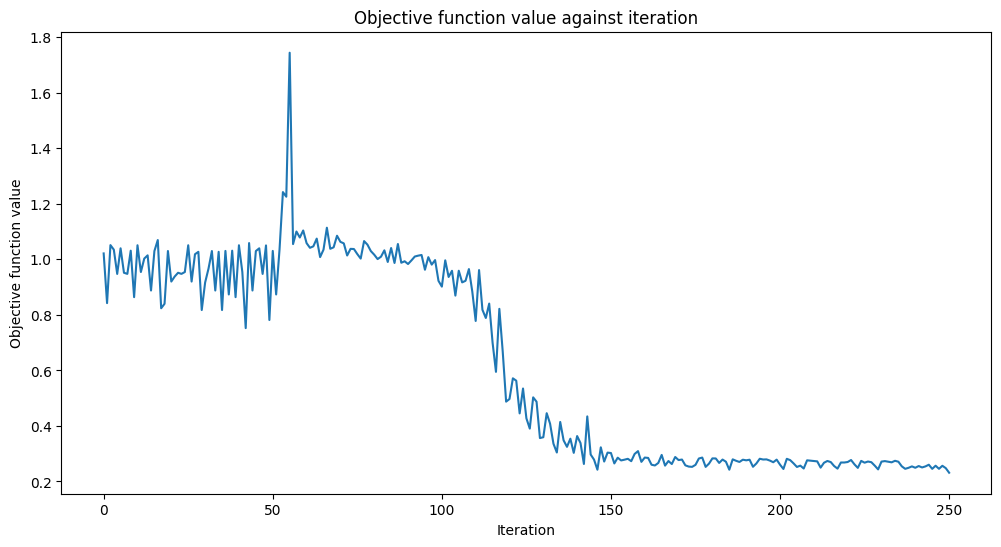

0.9

In [9]:
qnn = get_opflow_qnn(ttn_qc, feature_map, ansatz_ttn, hamiltonian_ttn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train)
X_train_norm = minmax_scale.transform(X_train)
X_test_norm = minmax_scale.transform(X_test)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_norm, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_norm, y_test)

### N vezes

Classes 1 e 2

In [7]:
class_a = 0
class_b = 1
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="TTN")

iteracao : 0
score:  1.0
iteracao : 1
score:  1.0
iteracao : 2
score:  0.95
iteracao : 3
score:  1.0
iteracao : 4
score:  1.0
Mean:  0.99
Std:  0.020000000000000018
[1.0, 1.0, 0.95, 1.0, 1.0]


Classes 1 e 3

In [8]:
class_a = 0
class_b = 2
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="TTN")

iteracao : 0
score:  0.95
iteracao : 1
score:  1.0
iteracao : 2
score:  1.0
iteracao : 3
score:  1.0
iteracao : 4
score:  1.0
Mean:  0.99
Std:  0.020000000000000018
[0.95, 1.0, 1.0, 1.0, 1.0]


Classes 2 e 3

In [5]:
class_a = 1
class_b = 2
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=10, ansatz_chosen="TTN")

iteracao : 0
score:  0.9
iteracao : 1
score:  0.9
iteracao : 2
score:  0.8
iteracao : 3
score:  0.95
iteracao : 4
score:  0.85
iteracao : 5
score:  0.9
iteracao : 6
score:  0.9
iteracao : 7
score:  0.95
iteracao : 8
score:  0.9
iteracao : 9
score:  0.95
Mean:  0.9
Std:  0.04472135954999577
[0.9, 0.9, 0.8, 0.95, 0.85, 0.9, 0.9, 0.95, 0.9, 0.95]
